# Pitch & Roll prediction w/Images

In [1]:
import gc
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
from PIL import Image
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 4
Platform: windows
number of workers: 0


# Constants

In [4]:
# change to appropriate location
TRAIN_FOLDER = "../3dmodel/test_4_episode_"

In [5]:
FRAMES_IN = 1
FRAMES_OUT = 10

N_EPISODES = 540
FRAMES_PER_EPISODE = 400
SEQUENCE_LENGTH = 50

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

CUDA = device.type == 'cuda'

# Load data from episodes

In [6]:
# view first episode 's datapoints
filename = TRAIN_FOLDER + "1/"
data = []
labels = json.load(open(filename+"labels_0.json"))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head(5)

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [7]:
img_tensors_array = []
filename = TRAIN_FOLDER + "1/"
for index, row in ep1.iterrows():
    img = cv2.imread(filename + str(index) + ".png")
    img_tensors_array.append(torch.Tensor(img))
ep1.head(5)

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [10]:
len(img_tensors_array), img_tensors_array[0].shape

(400, torch.Size([54, 96, 3]))

In [11]:
# Function to normalize pixels
def norm_pixel(x):
    x = x.astype('float32')
    return (x*2)/255-1

# Function to denormalize pixels
def denorm_pixel(x):
    x = x.astype('float32')
    return (x+1)*255/2

In [12]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to denormalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [13]:
# load all data
episodes_data = []
img_tensors_array = []

for ep in tqdm(range(1, N_EPISODES+1)):
    folder = TRAIN_FOLDER + str(ep) + "/"
    filename = folder + "labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        # load image, normalize and convert to tensor
        img = cv2.imread(folder + str(i) + ".png")
        img = norm_pixel(img)
        img_tensors_array.append(torch.Tensor(img))

        # pitch and roll is read with labels[i] as [pitch, roll]
        episodes_data.append(labels[i])

# verify that 216.000 images were loaded
len(img_tensors_array), img_tensors_array[0].shape

  0%|          | 0/540 [00:00<?, ?it/s]

(216000, torch.Size([54, 96, 3]))

In [14]:
# build dataframe with pitch and roll, cast as float and normalize
p_r_df = pd.DataFrame(episodes_data)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
print(p_r_df.shape)
p_r_df.head(5)

(216000, 2)


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


In [15]:
# tranform the array of image tensors into one tensor of shape: (samples, height, width, channels)
img_tensor = torch.stack(img_tensors_array)
img_tensor_array = None # free this memory
img_tensor.shape

torch.Size([216000, 54, 96, 3])

In [62]:
# clear memory
gc.collect()

1901

# Create input and output sequences

In [18]:
# function to create sequences with one target column
def create_sequences(
        input_data: pd.DataFrame, 
        input_images,
        input_feature_columns,
        output_target_columns, 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT,  
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-output_sequence_length-input_sequence_length+1):
            
            i = l+(n*episode_length)

            # grab image input tensors from list with img_tensors
            sequence = input_images[i:i+input_sequence_length]

            # grab pr output sequence from dataframe
            target_position = i + input_sequence_length
            target = input_data.iloc[target_position:target_position+output_sequence_length]

            sequences.append((sequence, target))

    return sequences

In [19]:
# use images to predict pitch and roll
input_features = []
output_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, img_tensor, input_features, output_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [20]:
len(all_sequences), all_sequences[0][0].shape , all_sequences[0][1].shape

(210600, torch.Size([1, 54, 96, 3]), (10, 2))

In [21]:
# first input sequence
all_sequences[0][0].shape

torch.Size([1, 54, 96, 3])

In [22]:
# first output sequence
all_sequences[0][1].head()

,pitch,roll
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061
5,-0.000724,0.034174


In [35]:
# loop for testing sequence integrity
"""
i = 0
for data in tqdm(all_sequences):
    input = data[0]
    output = data[1]

    episode = input.iloc[0]["episode"]
    episode1 = output.iloc[0]["episode"]
    
    if(episode1 != episode):
        print("Input and output from different episodes")
        break

    if (len(input['episode'].unique()) != 1):
        print("input seq: "+i+" contains data from different episodes")
        break
    
    if (len(output['episode'].unique()) != 1):
        print("output seq: "+i+" contains data from different episodes")
        break
    
    i += 1
"""

'\ni = 0\nfor data in tqdm(all_sequences):\n    input = data[0]\n    output = data[1]\n\n    episode = input.iloc[0]["episode"]\n    episode1 = output.iloc[0]["episode"]\n    \n    if(episode1 != episode):\n        print("Input and output from different episodes")\n        break\n\n    if (len(input[\'episode\'].unique()) != 1):\n        print("input seq: "+i+" contains data from different episodes")\n        break\n    \n    if (len(output[\'episode\'].unique()) != 1):\n        print("output seq: "+i+" contains data from different episodes")\n        break\n    \n    i += 1\n'

In [23]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
168480 42120
[167621, 29184, 6556, 194393, 72097, 64196, 58513, 36579, 193061, 26868]
[131073, 3, 4, 131078, 7, 8, 131083, 131088, 131089, 131090]


In [25]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/168480 [00:00<?, ?it/s]

  0%|          | 0/42120 [00:00<?, ?it/s]

True
168480 torch.Size([1, 54, 96, 3]) (10, 2)
42120 torch.Size([1, 54, 96, 3]) (10, 2)


## Pytorch Dataset and DataLoader

In [26]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = sequence,
            labels = torch.Tensor(labels.to_numpy())
        )

In [49]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [50]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [51]:
# batch size first
for batch in data_module.train_dataloader():
    print(batch["sequence"].shape)
    print(batch["labels"].shape)
    break

torch.Size([64, 1, 54, 96, 3])
torch.Size([64, 10, 2])


## CNN Model

In [54]:
class CNN_Sequence(nn.Module):

    def __init__(self, input_size):
        super(CNN_Sequence, self).__init__()
        

In [61]:
CNN_Sequence(2).__class__.__name__

'CNN_Sequence'

In [ ]:
class CNN_stack_FC_first(nn.Module):
    def __init__(self, cuda = True, num_channel = 3,  cnn_fc_size = 1024, num_output=20):
        super(CNN_stack_FC_first, self).__init__()
        self.cuda_p = cuda
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channel, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        )
        self.fc1 = nn.Linear(5376  , cnn_fc_size) #5376 / 20736
        self.fc2 = nn.Linear(cnn_fc_size, 128)
        self.fc3 = nn.Linear(128, num_output)
        self.dropout0 = nn.Dropout(p=0.3)
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p= 0.4)


    def forward(self, x, p_and_roll, num_images):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x =  torch.tanh(self.fc3(x)).view(x.size(0), -1, 2)

        return x

# Training

In [39]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 1, 54, 96, 3]) torch.Size([64, 10, 2])


### Training loop

In [99]:
model = CNN_Sequence(2)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []
train_losses_all_batches = []   # list with (epoch nr, [losses from all batches]) tuples

n_epochs = NUM_EPOCHS

for epoch in tqdm(range(n_epochs)):

    losses_current_batch = []

    for batch in data_module.train_dataloader():
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)
        if CUDA: 
            y_pred = y_pred.cuda()

        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_current_batch.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # add batch-losses to dictionary
    train_losses_all_batches.append((epoch, losses_current_batch))

    train_losses_epoch.append(loss.item())
    train_loss = round(loss.item(), 6)

    with torch.no_grad():
        for batch in data_module.val_dataloader():
            x_val = batch["sequence"]
            y_val = batch["labels"]

            if CUDA: 
                x_val = batch["sequence"].cuda()
                y_val = batch["labels"].cuda()
            
            # Predict on forward pass 
            y_pred = model.forward(x_val)
            if CUDA: 
                y_pred = y_pred.cuda()
            
        loss = criterion(y_pred, y_val)
        val_losses_epoch(loss.item())
        val_loss = round(loss.item(), 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (30) must match the size of tensor b (64) at non-singleton dimension 1

# Training results

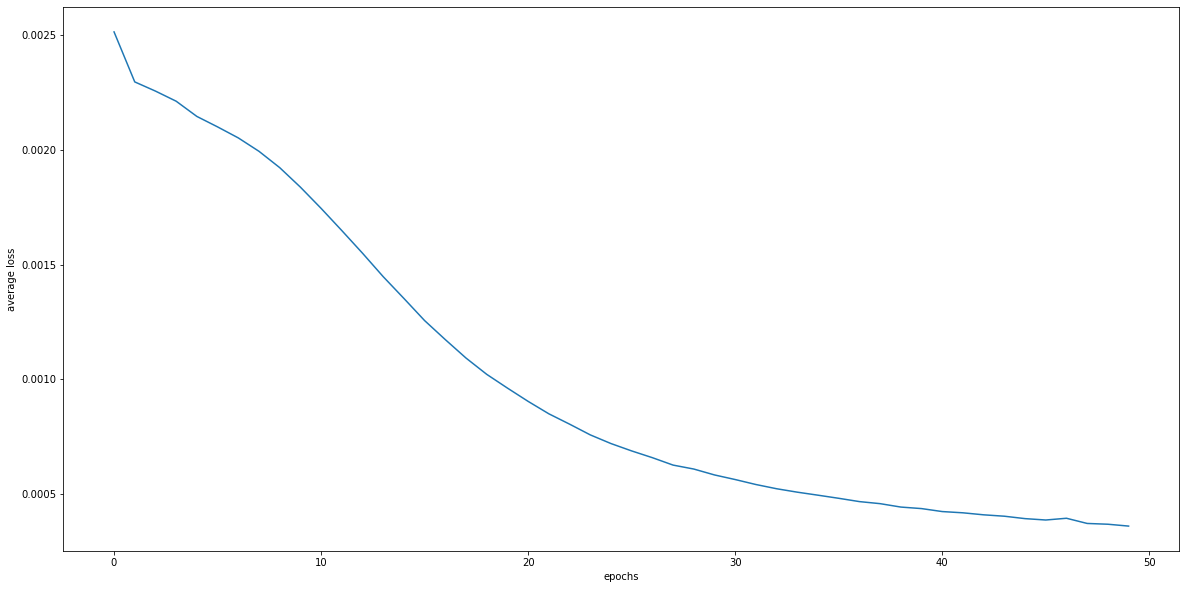

In [288]:
plt.figure(figsize=(15, 7))
plt.plot(range(n_epochs), train_losses_epoch, label='training loss')
plt.plot(range(n_epochs), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [249]:
filename = f'model_states/CNN_img-to-PR_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

In [276]:
filename = f'model_states/CNN_img-to-PR_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = CNN_Sequence(FRAMES_IN)
loaded_model.load_state_dict(torch.load('model_states/PR_LSTM_sequence'))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

PRPredictionModel(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=128, out_features=2, bias=True)
)

# Testing

In [289]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 50, 2]) torch.Size([1, 2])


In [305]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

prediction:	tensor([[0.2471, 0.1820]], device='cuda:0')
real:		tensor([[0.2538, 0.1659]], device='cuda:0')
loss: 0.0001526541163912043


### Prediction vs. real on first test I/O-sequence

In [ ]:
frames = np.arange(0,FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[0], output_sequence[0])), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[0], color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (normalized)')
ax.set_title('30 to 10 prediction results')
plt.legend()
plt.show()

In [ ]:
frames = np.arange(0,FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[1], output_sequence[1])), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[1], color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (normalized)')
ax.set_title('30 to 10 prediction results')
plt.legend()
plt.show()

### Full test loop

In [324]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        output = loaded_model(x_test)
        predictions.append(output.detach().to('cpu').numpy().flatten())
        labels.append(y_test.detach().to('cpu').numpy().flatten())

  0%|          | 0/37800 [00:00<?, ?it/s]

In [329]:
# Predictions[0] = np array object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

### Average loss-per-frame over all datapoints

In [ ]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [ ]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(pitch_lpf_mse, label='pitch')
plt.plot(roll_lpf_mse, color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('MSE Loss')
plt.title('Loss per frame: MSE')
plt.legend()
plt.show()

In [ ]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 4))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.show()

### MSE results pitch

In [ ]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

### MSE results roll

In [ ]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")